In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split 
import seaborn as sns


In [2]:
df = pd.read_csv('./data/train.csv', sep='|')
test = pd.read_csv('./data/test.csv', sep='|')

# Data Understanding & Feature Engineering

In [3]:
df.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


Looking at the data at second glance, I saw that the column for the total amount of scanned line items is missing. 
Luckily, it can be calculated using the totalScanTimeInSeconds and the scannedLineItemsPerSecond columns. 

In [4]:
df['scannedLineItems'] = (df['totalScanTimeInSeconds']*df['scannedLineItemsPerSecond']).apply(lambda x: np.around(x, 2))

In [5]:
# check if we only have integer numbers
df['scannedLineItems'].unique()

array([29., 14., 13., 27., 26., 11., 10., 16., 20., 21.,  6., 22., 24.,
        4., 19., 15.,  5.,  8.,  1.,  9., 30., 25.,  7.,  2., 28., 23.,
       17., 18.,  3., 12.])

In [6]:
# convert the dtype to int
df['scannedLineItems'] = df['scannedLineItems'].astype(int)

In [7]:
# Getting an overview of the whole dataset by using pandas-profiling
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [8]:
# looking if any values are missing, how they are distributed, and if there are any significant correlations
# of the features with the label 

# Create an html file for submission 
profile.to_file(output_file="data-profile.html")

# Showing profile inline
profile

In [9]:
df.corr()['fraud'].sort_values()

trustLevel                  -0.319765
lineItemVoidsPerPosition    -0.090116
valuePerSecond              -0.028873
scannedLineItemsPerSecond   -0.023085
quantityModifications       -0.000864
grandTotal                   0.001421
lineItemVoids                0.063496
scansWithoutRegistration     0.074123
totalScanTimeInSeconds       0.110414
scannedLineItems             0.298423
fraud                        1.000000
Name: fraud, dtype: float64

There are a few features, that correlate significantly with the data, namly trustLevel and scannedLineItems 

In [10]:
# divide the data by the label for data exploration purpose
non_fraud, fraud = df[df['fraud']==0], df[df['fraud']==1]

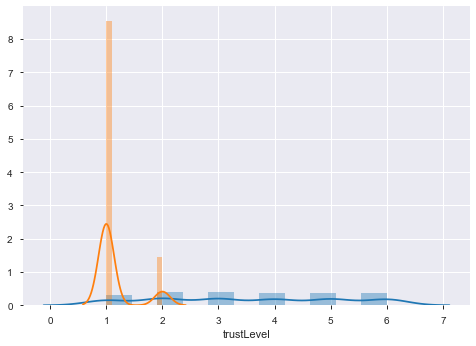

In [11]:
# Plot the distribution of trustlevel divided by the label
sns.distplot(non_fraud['trustLevel'])
sns.distplot(fraud['trustLevel'])

In [12]:
fraud['trustLevel'].value_counts()

1    89
2    15
Name: trustLevel, dtype: int64

Fraud transactions (orange color) always have a trustLevel below 3 

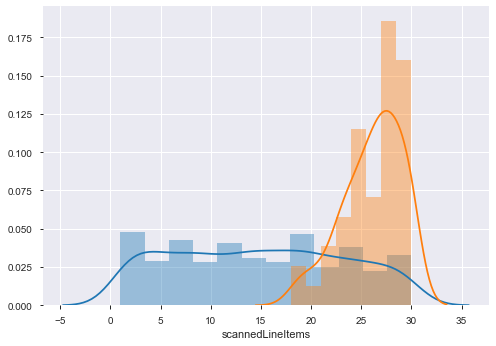

In [13]:
sns.distplot(non_fraud['scannedLineItems'])
sns.distplot(fraud['scannedLineItems'])

In [14]:
fraud['scannedLineItems'].value_counts()

27    15
30    14
28    14
29    11
26    11
25    11
23     9
24     7
22     3
21     3
19     3
20     2
18     1
Name: scannedLineItems, dtype: int64

Fraud transactions (orange color) always contain more than 17 Items

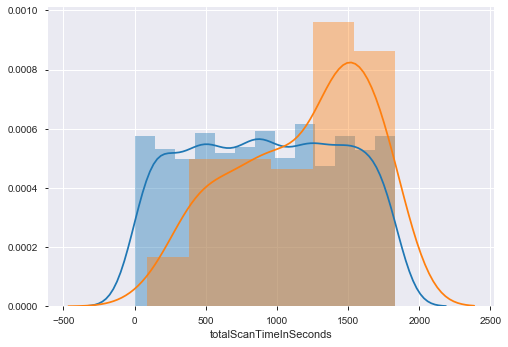

In [15]:
sns.distplot(non_fraud['totalScanTimeInSeconds'])
sns.distplot(fraud['totalScanTimeInSeconds'])

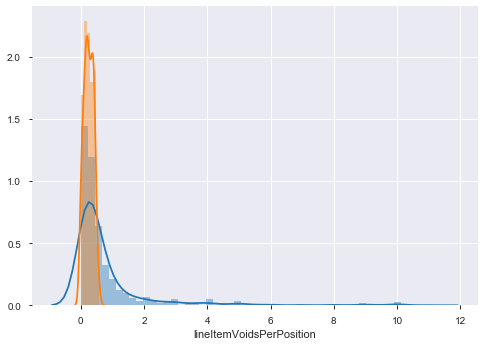

In [16]:
sns.distplot(non_fraud['lineItemVoidsPerPosition'])
sns.distplot(fraud['lineItemVoidsPerPosition'])

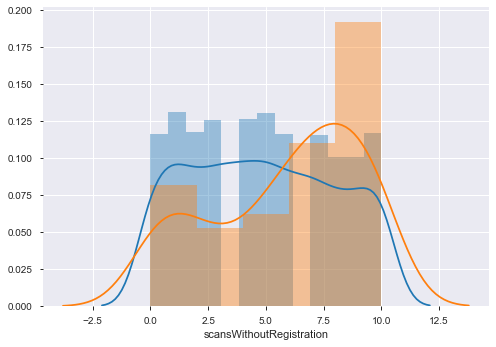

In [17]:
sns.distplot(non_fraud['scansWithoutRegistration'])
sns.distplot(fraud['scansWithoutRegistration'])

The last 3 plots don't help us that much in finding a general rule

# Models

In [18]:
# Split the data in features and labels
X = df.drop(['fraud'], axis=1)
y = df['fraud']

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score

In [20]:
# create the error function, that is demanded by the challenge rules
# adapt the the error to display the value per line item, so it is comparable between different dataset sizes
def challenge_error(y_true, y_pred, print_stats=False): 
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    # convert to array, or else we can get strange key errors
    y_true = list(y_true)
    y_pred = list(y_pred)
    
    # determine TP, FP, TN and FN 
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_pred[i]!=y_true[i]:
            FP += 1
        if y_true[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_pred[i]!=y_true[i]:
            FN += 1
    # option to display detailed results        
    if print_stats: 
        print("TP (correctly identified fraud): {} - {}€\nFP (incorrectly labeled fraud): {} - {}€\nFN (missed fraud detection): {} - {}€\nTN: {}\n\nTotal: {}€"
                .format(TP, TP*5, FP, FP*-25, FN, FN*-5, TN, TP*5+FP*-25+FN*-5))
    
    return (TP*5 + FP*-25 + FN*-5)/len(y_true)
    

In [21]:
# make error function a scoring function for scikit-learn
scoring = {'error' : make_scorer(challenge_error)}

## DummyClassifier

At first, I will see how a dummy classifier would perform 
Here I decided to check what the error score would be, if we wouldn't try to detect frauds at all 

In [22]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent')
clf.fit(X,y)
y_pred = clf.predict(X)
challenge_error(y, y_pred, print_stats=True)

TP (correctly identified fraud): 0 - 0€
FP (incorrectly labeled fraud): 0 - 0€
FN (missed fraud detection): 104 - -520€
TN: 1775

Total: -520€


-0.2767429483767962

This will be the first baseline, that other models will have to top

## Logical Reasoning

### Part 1

We already saw a few patterns in the data.
Maybe we can just built some basic general rules, that will help us detect the frauds?! 

In [23]:
# Check how many data points would be fraud and non-fraud using the general rule
df[(df['trustLevel']<=2) & (df['scannedLineItems']>=18)]['fraud'].value_counts()

0    191
1    104
Name: fraud, dtype: int64

In [24]:
df[~(df['trustLevel']<=2) & (df['scannedLineItems']>=18)]['fraud'].value_counts()

0    520
Name: fraud, dtype: int64

We can see, that we narrowed down the data to a smaller set (suspicious transactions), while still not missing any frauds

In [25]:
# check performance using the general rule
y_pred = np.where(((X['trustLevel']<=2)&(X['scannedLineItems']>=18)), 1, 0)
challenge_error(y, y_pred, print_stats=True)

TP (correctly identified fraud): 104 - 520€
FP (incorrectly labeled fraud): 191 - -4775€
FN (missed fraud detection): 0 - 0€
TN: 1584

Total: -4255€


-2.2645023948908993

This didn't go well, mainly because we labeled a lot of transactions as fraud that weren't. 
Because this is penalized very strong, we actually performing worse than not trying to detect any frauds at all. 

### Part 2

We can try to adjust our rule, by not labeling every suspicious transaction as fraud, but by actually looking at the percentage of transactions that are fraud in the suspicious transactions and labeling them using this relative frequency

In [26]:
# Use the rule identified above: trustLevel below 3 and scannedLineItems above 17
pattern = df[(df['trustLevel']<=2) & (df['scannedLineItems']>=18)]['fraud'].value_counts()
p1 = pattern[0]/pattern.sum()
p2 = pattern[1]/pattern.sum()
p2

0.3525423728813559

35% of the suspicous transactions are fraud

In [27]:
y_pred = []
for _, val in X.iterrows():
    if (val['trustLevel']<=2) & (val['scannedLineItems']>=18):
        y_pred.append(np.random.choice(2, p=[p1, p2]))
    else:
        y_pred.append(0)
challenge_error(y, y_pred, print_stats=True)

TP (correctly identified fraud): 35 - 175€
FP (incorrectly labeled fraud): 74 - -1850€
FN (missed fraud detection): 69 - -345€
TN: 1701

Total: -2020€


-1.0750399148483236

This worked way better than the first try but not as good as not detecting any frauds at all. 
We still have a huge amount of transactions incorretly labeled as fraud. 

### Part 3

With the huge penalty for FPs in mind, we can generate a stricter rule, when we classify suspicous transactions as fraud. 


In [28]:
# Change the rule to trustLevel below 2 and scannedLineItems above 22
pattern = df[(df['trustLevel']<=1) & (df['scannedLineItems']>=23)]['fraud'].value_counts()
p1 = pattern[0]/pattern.sum()
p2 = pattern[1]/pattern.sum()
p2

0.7777777777777778

Now 77.7% of the suspicious transactions are actually fraud. 
That relative frequency is used again to identify fraud transactions

In [29]:
y_pred = []
for _, val in X.iterrows():
    if (val['trustLevel']<=1) & (val['scannedLineItems']>=25):
        y_pred.append(np.random.choice(2, p=[p1, p2]))
    else:
        y_pred.append(0)
challenge_error(y, y_pred, print_stats=True)

TP (correctly identified fraud): 48 - 240€
FP (incorrectly labeled fraud): 11 - -275€
FN (missed fraud detection): 56 - -280€
TN: 1764

Total: -315€


-0.16764236295902077

Now we are actually performing better than not labeling frauds at all! 
Let's use that as our new baseline. 

## SVM / SVC / SGDClassifier

In [30]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

# random seed
rs = 1 

clf1 = LinearSVC(random_state=rs)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
scores = cross_validate(clf1, X_scaled, y, cv=5, scoring=scoring, return_train_score=True)
print(scores['test_error'].mean())
scores


0.17295744680851063


{'fit_time': array([0.00399947, 0.00399971, 0.        , 0.00400066, 0.0040133 ]),
 'score_time': array([0.        , 0.        , 0.00399947, 0.        , 0.        ]),
 'test_error': array([0.06648936, 0.22606383, 0.27925532, 0.13297872, 0.16      ]),
 'train_error': array([0.22621424, 0.17964072, 0.15968064, 0.17964072, 0.1462766 ])}

In [31]:
from sklearn.svm import SVC
clf2 = SVC(random_state=rs)
scores = cross_validate(clf2, X_scaled, y, cv=5, scoring=scoring, return_train_score=True)
print(scores['test_error'].mean())
scores

0.07711347517730496


{'fit_time': array([0.01199818, 0.00801039, 0.01199889, 0.0080018 , 0.00799918]),
 'score_time': array([0.        , 0.        , 0.        , 0.00400233, 0.        ]),
 'test_error': array([ 0.07978723,  0.07978723,  0.17287234,  0.07978723, -0.02666667]),
 'train_error': array([0.166334  , 0.17631404, 0.1497006 , 0.14304724, 0.11968085])}

In [32]:
from sklearn.linear_model import SGDClassifier
clf3 = SGDClassifier(random_state=rs)
scores = cross_validate(clf3, X_scaled, y, cv=5, scoring=scoring, return_train_score=True)
print(scores['test_error'].mean())
scores

0.11179432624113476


{'fit_time': array([0.00202727, 0.        , 0.00400305, 0.        , 0.        ]),
 'score_time': array([0.        , 0.        , 0.        , 0.00400329, 0.        ]),
 'test_error': array([-0.1462766 ,  0.1462766 ,  0.21276596,  0.17287234,  0.17333333]),
 'train_error': array([-0.11310712,  0.12974052,  0.0998004 ,  0.12974052,  0.15625   ])}

This worked pretty well already! 
With scaled features we achieve a positive score, meaning we would actually make money with our new method. 

## Voting Classifier

In [33]:
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[('svm', clf1), ('svc', clf2), ('sgd', clf3)], voting='hard')
scores = cross_validate(eclf1, X_scaled, y, cv=5, scoring=scoring, return_train_score=True)
print(scores['test_error'].mean())
scores

0.1915744680851064


{'fit_time': array([0.01606035, 0.01326251, 0.01204538, 0.01200151, 0.01200008]),
 'score_time': array([0.00398278, 0.00398469, 0.00399542, 0.00400352, 0.00400043]),
 'test_error': array([0.09308511, 0.22606383, 0.27925532, 0.19946809, 0.16      ]),
 'train_error': array([0.20958084, 0.166334  , 0.17298736, 0.1497006 , 0.15625   ])}

Instead of deciding for one classifier, we can just use the 3 of them combined and use a voting classifier ontop, that assigns the label according to the majority vote.
As we can see, it also performs better on our training set. 

## Labeling final submission data

In [34]:
# Use the ensemble classifier for labeling the submission data
eclf1.fit(X_scaled,y) 

VotingClassifier(estimators=[('svm',
                              LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=1, tol=0.0001,
                                        verbose=0)),
                             ('svc',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scal...
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                  

In [35]:
X_test = test
# "Pipeline" to calculate scannedLineItems feature
X_test['scannedLineItems'] = (test['totalScanTimeInSeconds']*test['scannedLineItemsPerSecond']).apply(lambda x: np.around(x, 2)).astype(int)
X_test_scaled = scaler.transform(X_test)

In [36]:
y_pred = eclf1.predict(X_test_scaled)

In [37]:
output = pd.DataFrame({'fraud': y_pred})
output.to_csv('./data/Luis_Habenicht-prediction.csv', index=False)